In [1]:
import pandas as pd
import numpy as np
import sidetable
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
from pycoingecko import CoinGeckoAPI
from datetime import date
import datetime

scope = pd.read_csv(r"/Users/fernandoseguias/Desktop/ferseg/Proyectos/Programacion/iron_hack/project_1/output/scope.csv")


luna_scope = scope.loc[scope["coin"] == "luna"]
luna_scope["coin"] = "luna"
ust_scope = scope.loc[scope["coin"] == "ust"]
ust_scope["coin"] = "ust"
scope = pd.concat([luna_scope.tail(350), ust_scope.tail(350)], join='outer')
scope["period"] = scope["date"].astype("str")


#api link to download important missing data about luna supply
cg = CoinGeckoAPI()

from_ = date(2018, 12, 31)
to_ = date(2021, 12, 31)

unix_from = from_.strftime('%s')
unix_to = to_.strftime('%s')

df = pd.DataFrame(cg.get_coin_market_chart_range_by_id(id="terra-luna", vs_currency="usd", from_timestamp=unix_from, to_timestamp=unix_to))

def mc_transfor(df):
    #get values in lists and drop old colums
    #def get_value(x):
    #    return x[1]
    df[['date','price']] = pd.DataFrame(df.prices.tolist(), index= df.index)
    #df['market_cap'] = df["market_caps"].apply(get_value)
    df['market_cap'] = df["market_caps"].apply(lambda x : x[1])
    #df['total_volume'] = df["total_volumes"].apply(get_value)
    df['total_volume'] = df["total_volumes"].apply(lambda x : x[1])
    df.drop(["prices", "market_caps", "total_volumes"], axis=1, inplace=True)

    #change types: date to datetime / coin to category / floats to round float
    #def date_clean(x):
    #    return datetime.datetime.fromtimestamp(x / 1e3)
    #df["date"] = df["date"].apply(date_clean)
    df["date"] = df["date"].apply(lambda x : datetime.datetime.fromtimestamp(x / 1e3))
    df["date"] = df["date"].dt.strftime('%d/%m/%Y')
    df["price"] = df["price"].astype(float).round(5)
    df[["market_cap", "total_volume"]] = df[["market_cap", "total_volume"]].astype(int)
    df["supply"] = df["market_cap"] / df["price"]
    return df

mc_transfor(df)

/Users/fernandoseguias/opt/anaconda3/lib/python3.9/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


,date,price,market_cap,total_volume,supply
0,08/05/2019,3.26998,0,6703686,0.000000e+00
1,09/05/2019,3.30807,0,10600884,0.000000e+00
2,10/05/2019,3.08217,0,33710121,0.000000e+00
3,11/05/2019,3.03693,0,885232,0.000000e+00
4,12/05/2019,2.77590,0,942632,0.000000e+00
...,...,...,...,...,...
963,26/12/2021,98.54673,35987270821,2645746335,3.651798e+08
964,27/12/2021,99.91987,36318541738,2214941962,3.634767e+08
965,28/12/2021,90.92075,33104651657,2807973038,3.641045e+08
966,29/12/2021,85.52958,31278247237,3245491414,3.657009e+08


In [ ]:
#facebook announcement its name change to meta 28-oct-2021
fig, axes = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=False)
sns.lineplot(data=scope, x="period", y="close", hue="coin")

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=False)
ust_scope = scope.loc[scope["coin"] == "ust"]
sns.lineplot(data=ust_scope, x="period", y="circulating_supply")

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=False)
luna_scope = df.tail(350)
sns.lineplot(data=luna_scope, x="date", y="supply")

<AxesSubplot:xlabel='date', ylabel='supply'>

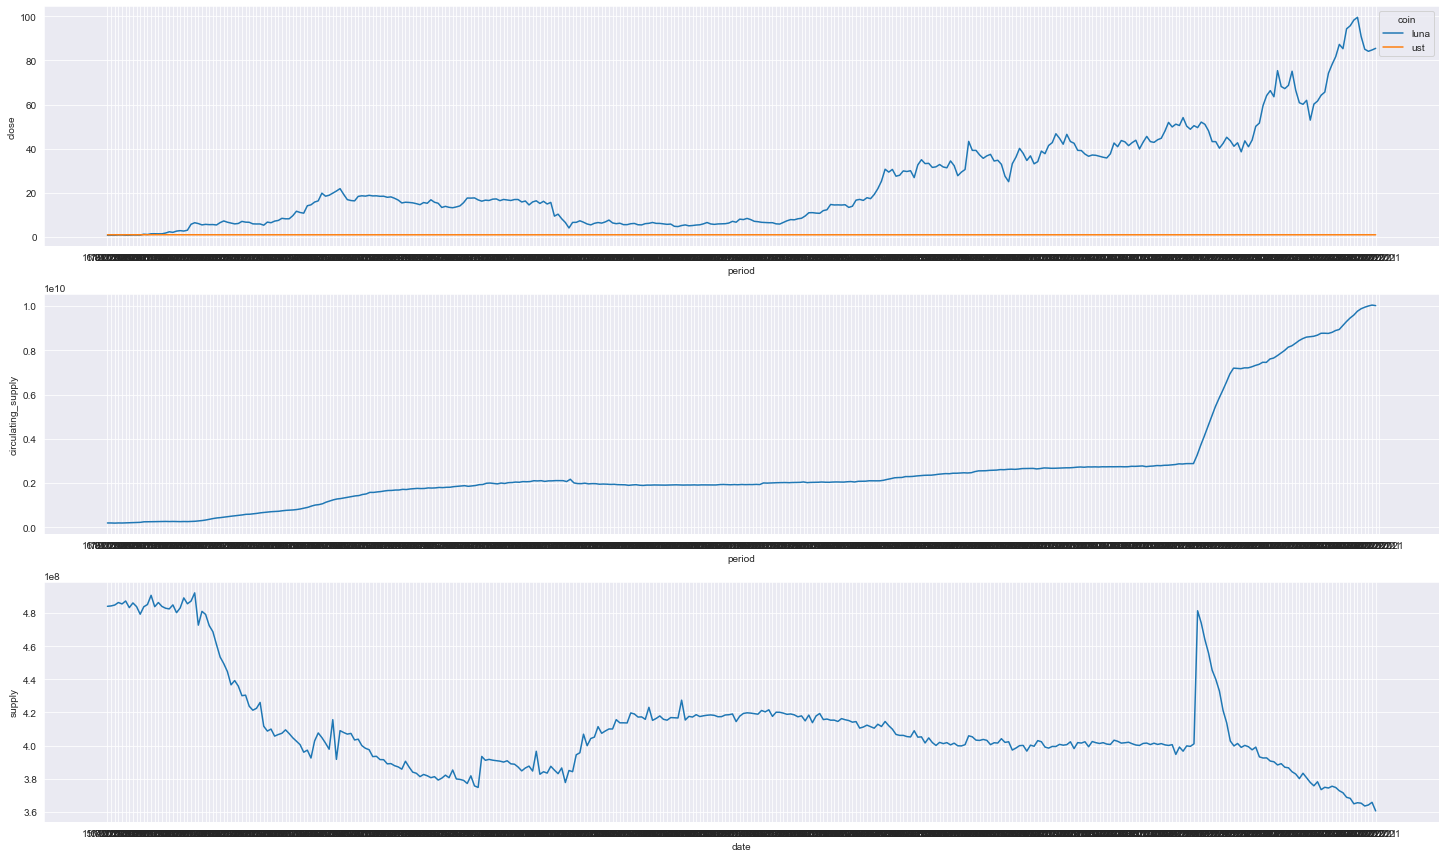

In [7]:
#luna and ust price - note that ust is pegged to us dollar
fig, axes = plt.subplots(3, 1, figsize=(25, 15), sharex=False, sharey=False)
sns.lineplot(data=scope, x="period", y="close", hue="coin", ax=axes[0])
ust_scope = scope.loc[scope["coin"] == "ust"]
sns.lineplot(data=ust_scope, x="period", y="circulating_supply", ax=axes[1])
luna_scope = df.tail(350)
sns.lineplot(data=luna_scope, x="date", y="supply", ax=axes[2])